In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-26 15:52:11,386 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        data.append(row)
    return pd.DataFrame(data)

In [3]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model, adjust_bias), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        y_test = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        print(y_test.shape)
        zero = np.isclose(y_test['area'], 0)
#         y_test = y_test[np.logical_not(zero)]
#         y_pred = y_pred[np.logical_not(zero)]
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
        y_test['compactness'] = 1.0 / (y_test['compactness'] / (4 * np.pi))
        y_pred['compactness'] = 1.0 / (y_pred['compactness'] / (4 * np.pi))
        
        if model == 'A':
            y_pred['orientation'] = 0
            y_pred['eccentricity'] = 0
            y_pred['compactness'] = np.minimum(1, np.maximum(0, y_pred['compactness']))
            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'adjust_bias': adjust_bias,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [4]:
results_dir = '../../results/shape6cv/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 409 files


In [5]:
subjects = ['TB', '12-005', '51-009', '52-001']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [6]:
data = load_data(pickle_files, verbose=False)

In [7]:
data.columns

Index(['adjust_bias', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [8]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [9]:
data.groupby(groupcols + ['idx_fold'], sort=False)['exetime', 'best_train_cost'].agg(['mean', 'std', 'count'])

exetime                     \
                                           mean          std count   
subject model adjust_bias idx_fold                                   
12-005  A     False       0          156.984015     8.767356     5   
                          1          132.066654    59.060407     5   
                          2          135.412353    57.162627     5   
                          3          132.420177    59.517484     5   
                          4          158.878267     9.609827     5   
                          5          155.241122    11.165767     5   
                          6          127.331880    66.258016     5   
                          7          157.108145    10.328058     5   
                          8          156.209074     8.266656     5   
        C     False       0          874.880493   368.973379     5   
                          1         1622.453928   577.183671     5   
                          2         1243.343367   515.786434     5   
                          3         1248.985731   668.557714     5   
                          4         1181.520989   314.346439     5   
                          5          944.339447   395.190808     5   
                          6         1360.602560   917.781606     5   
                          7         1166.431900   778.576188     5   
                          8         1296.745997   338.511046     5   
51-009  A     False       0          177.911562    11.030665     5   
                          1          173.786274    16.257395     5   
                          2          171.966981    13.346332     5   
                          3          170.523489    14.953012     5   
                          4          171.623129    13.952139     5   
                          5          169.611372    15.011997     5   
                          6          167.005614    14.453890     5   
                          7          172.733899    16.367397     5   
                          8          169.128325    16.193611     5   
        C     False       0         1199.178867   440.442641     5   
                          1         7144.060592  2179.197496     5   
                          2         6977.067738  2055.701072     5   
...                                         ...          ...   ...   
52-001  C     False       1         1723.033730   936.601204     5   
                          10        7524.041644  7641.834296     5   
                          11        4571.564475  7486.287408     5   
                          12        1790.875888   648.854060     5   
                          13        1101.230282   700.553770     5   
                          14        1822.248265   583.441068     5   
                          2         1784.051976   575.953193     5   
                          3         1579.441423   693.354896     5   
                          4         1463.885462   303.854570     5   
                          5         1869.329827  1270.963797     5   
                          6         7736.055018  7782.715586     5   
                          7         1793.152645   580.020559     5   
                          8          967.227523   498.773333     5   
                          9         1635.201851   651.731518     5   
TB      A     False       0           52.000981     5.911640     5   
                          1           56.108585     2.323231     5   
                          2           55.439025     0.804003     5   
                          3           54.498931     0.810947     5   
                          4           54.890583     0.922152     5   
                          5           55.366662     1.139681     5   
                          6           55.825109     1.251222     5   
                          7           55.470796     1.125728     5   
        C     False       0         3992.887081  2711.886427     5   
                          1         1620.818482   

# The best runs in their respective category

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])['best_train_cost'].agg(['count',
                                                                                                        'min'])

Best scores:


count          min
subject model adjust_bias idx_fold                    
12-005  A     False       0             1    13.805785
                          1             1    14.506057
                          2             1    12.504909
                          3             1    12.261443
                          4             1    12.332753
                          5             1    24.274550
                          6             1    13.177385
                          7             1    12.463275
                          8             1    13.533986
        C     False       0             1     5.962077
                          1             1     5.785749
                          2             1     5.927492
                          3             1     6.144052
                          4             1     4.734306
                          5             1     9.744147
                          6             1     5.451529
                          7             1     6.175855
                          8             1     6.577722
51-009  A     False       0             1  2576.543697
                          1             1  2141.270529
                          2             1  2982.131798
                          3             1  2906.509256
                          4             1  3752.400162
                          5             1  3204.157023
                          6             1  2325.053117
                          7             1  3038.582443
                          8             1  3861.894266
        C     False       0             1     4.811835
                          1             1    10.814755
                          2             1     6.263412
...                                   ...          ...
52-001  C     False       1             1     3.056242
                          2             1     2.947915
                          3             1     3.192419
                          4             1     3.073894
                          5             1     2.836683
                          6             1     3.485486
                          7             1     3.174830
                          8             1     3.884972
                          9             1     3.178388
                          10            1     4.057481
                          11            1     3.364628
                          12            1     3.246338
                          13            1     3.131444
                          14            1     3.181784
TB      A     False       0             1    36.017204
                          1             1    22.584077
                          2             1    20.531210
                          3             1    20.279050
                          4             1    19.556402
                          5             1    19.857212
                          6             1    18.317405
                          7             1    20.961966
        C     False       0             1     7.312305
                          1             1     5.391715
                          2             1     5.296752
                          3             1     5.154129
                          4             1     5.380115
                          5             1     5.752554
                          6             1     5.585194
                          7             1     6.029443

[82 rows x 2 columns]

In [11]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

(9, 4)
(9, 4)
(9, 4)
(9, 4)
(15, 4)
(15, 4)
(8, 4)
(8, 4)


,adjust_bias,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,False,45.260245,A,-5.734132,-8.582708,-26.713731,-0.229674,12-005,area compactness eccentricity orientati...,area compactness eccentricity orienta...
1,False,7.979236,C,-0.075761,-2.043588,-2.075864,0.215977,12-005,area compactness eccentricity orienta...,area compactness eccentricity orienta...
2,False,28950.112811,A,-2.163238,-61.036205,-28880.297331,-2.616036,51-009,area compactness eccentricity orientat...,area compactness eccentricity orient...
3,False,1468.634716,C,0.150106,-8.758963,-1455.805148,-0.220711,51-009,area compactness eccentricity orienta...,area compactness eccentricity orient...
4,False,37.286766,A,-5.556621,-5.720529,-22.381082,0.371466,52-001,area compactness eccentricity orientat...,area compactness eccentricity orien...
5,False,4.628648,C,-0.220249,-1.158033,0.094577,0.655058,52-001,area compactness eccentricity orien...,area compactness eccentricity orien...
6,False,233.036328,A,-5.697755,-9.480410,-213.613720,-0.244443,TB,area compactness eccentricity orientat...,area compactness eccentricity orient...
7,False,7.838529,C,-1.568603,-0.536572,-2.329717,0.596363,TB,area compactness eccentricity orienta...,area compactness eccentricity orient...


# Plot predictions

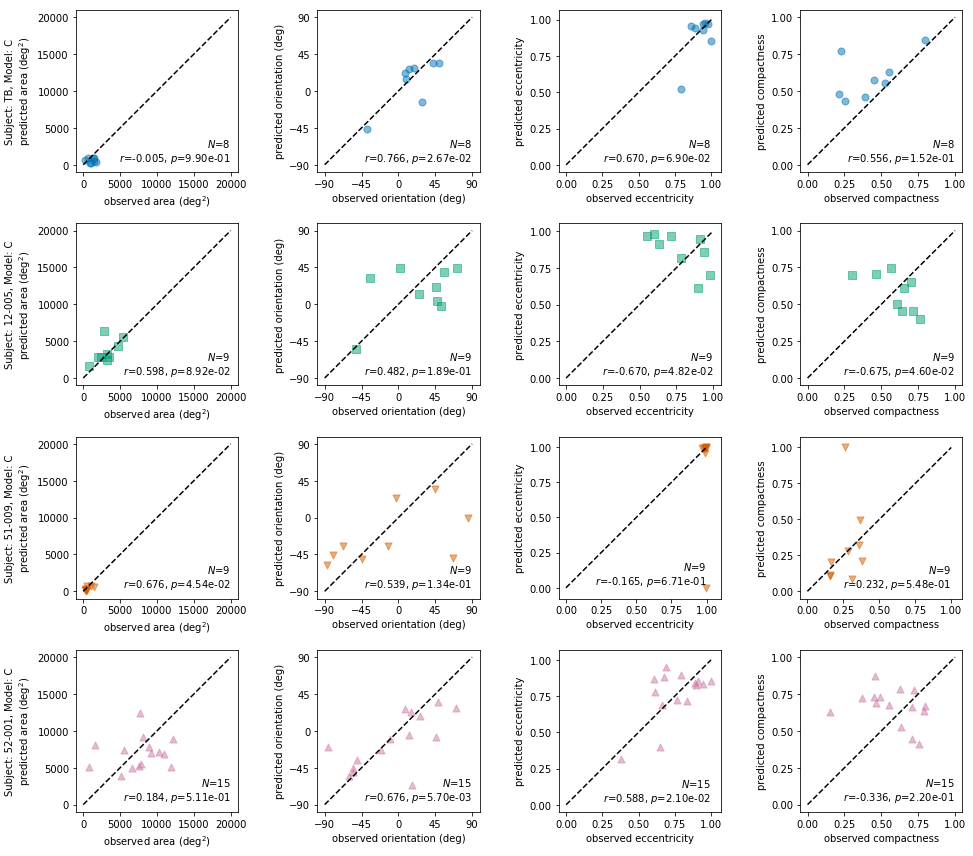

In [13]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 20000], [-90, 90], [0, 1], [0, 1]]
limits = [[-2000, 22000], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (row['subject'], row['model'], labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.png' % plotmodel)